# Data Processing and Performance Exploration - Data Analysis Course

**Welcome** to the Data Processing and Performance Exploration task! In this assignment, you will explore the **Big Sales data** dataset from [Kaggle](https://www.kaggle.com/datasets/pigment/big-sales-data/data) (we only need the Books_rating.csv from there), focusing on calculating a "dummy sentiment score" measure using different data processing tools. The goal is to analyze the memory usage and execution time of these tools—**Pandas**, **Dask**, and **PySpark**—and compare their performance.

**Exploration and Tools**  
Explore the following tools to process large datasets and measure performance:

- [Pandas Documentation](https://pandas.pydata.org/)
- [Dask Documentation](https://dask.org/)
- [PySpark Documentation](https://spark.apache.org/docs/latest/api/python/)

You will be using Python (specifically **Pandas**, **Dask**, and **PySpark**) to handle the dataset and compute the sentiment score. Be sure to pay attention to memory usage and processing time during the computations.

**Task Description**  
1. Download the **Books_rating.csv** from the following Kaggle dataset: [Big Sales Data](https://www.kaggle.com/datasets/pigment/big-sales-data/data).
2. Create a function `process_text(text)` that computes a **dummy sentiment score** for each review. The sentiment score should be calculated as the sum of the Unicode values of all characters in the review, modulo 100. Here’s a template for the function:

    ```python
    import re

    def process_text(text):
        words = re.findall(r'\w+', text)  # Tokenize words
        word_count = len(words)  # Count words
        sentiment_score = sum(ord(c) for c in text) % 100  # Fake sentiment calculation
        return word_count, sentiment_score
    ```
3. Perform the calculation using **Pandas**, **Dask**, and **PySpark** and compare the **memory usage** and **execution time** of each tool.
4. Explore the trade-offs between each library in terms of performance, scalability, and ease of use.
5. **Visualizations**:
    - Create visualizations for **execution time** and **memory usage** for each library. Use appropriate libraries such as **Matplotlib** or **Seaborn** to plot your results.
    - Use the `%%time` magic command in Jupyter to measure execution time for each tool.
    - For **Dask**, consider using `dask.delayed` or similar techniques for more efficient parallel computation. Experiment with different Dask functions and compare the results.
  
**Metrics to Analyze:**
- **Memory Usage**: How much memory does each library consume when processing the data? Use memory profiling tools to measure the memory footprint.
- **Execution Time**: Measure how long it takes for each tool to complete the sentiment score calculation. Use appropriate timing functions (e.g., `time.time()` or `datetime.now()`) or Jupyter's `%%time` magic command.

**Submission Instructions**  
Upload your solution to GitHub, adding the notebook and any related files to your existing project repository.

**Visualizations and Figures**  
For each tool, include visualizations (e.g., execution time and memory usage comparisons) that clearly show how each tool performs in terms of resource usage.

If you are interested in the topic, check out:
http://daslab.seas.harvard.edu/classes/cs265/


In [ ]:
import time
import pandas as pd

import dask.dataframe as dd
import psutil
import re

import pyarrow
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import matplotlib.pyplot as plt
import seaborn as sns


# Task 2
def process_text(text):
    if not isinstance(text, str):  # Handle NaN or non-string values
        return 0, 0
    words = re.findall(r'\w+', text)  # Tokenize words
    word_count = len(words)           # Count words
    sentiment_score = sum(ord(c) for c in text) % 100  # Fake sentiment calculation
    return word_count, sentiment_score


def pandas_execution():
    # Measure memory before processing
    memory_before = psutil.Process().memory_info().rss / (1024 ** 2)

    start_time = time.time()

    data = pd.read_csv("Books_rating.csv")
    # Fill NaN values in "review/text" with an empty string
    data['review/text'] = data['review/text'].fillna('')

    data[['word_count', 'sentiment_score']] = data['review/text'].apply(process_text).apply(pd.Series)
    data.to_csv('Books_rating_processed.csv', index=False)

    # After processing
    end_time = time.time()
    memory_after = psutil.Process().memory_info().rss / (1024 ** 2)

    pandas_execution_time = end_time - start_time
    pandas_memory_usage = memory_after - memory_before

    return pandas_execution_time, pandas_memory_usage

In [ ]:
def dask_execution():
    # Measure memory before processing
    memory_before = psutil.Process().memory_info().rss / (1024 ** 2)
    start_time = time.time()

    # Read data with Dask - explicitly set Id column to 'object' type
    data = dd.read_csv("Books_rating.csv", dtype={'Id': 'object'})

    # Fill NaN values in "review/text" with an empty string
    data['review/text'] = data['review/text'].fillna('')

    # Apply the function and handle the returned tuple
    results = data['review/text'].apply(
        process_text,
        meta=('review/text', 'object')
    )

    # Extract word_count and sentiment_score from the results
    data['word_count'] = results.map(lambda x: x[0] if isinstance(x, tuple) else 0,
                                     meta=('word_count', 'int'))
    data['sentiment_score'] = results.map(lambda x: x[1] if isinstance(x, tuple) else 0,
                                          meta=('sentiment_score', 'int'))

    # Write to csv
    data.to_csv('Books_rating_processed_dask.csv', index=False)

    # After processing
    end_time = time.time()
    memory_after = psutil.Process().memory_info().rss / (1024 ** 2)
    dask_execution_time = end_time - start_time
    dask_memory_usage = memory_after - memory_before

    return dask_execution_time, dask_memory_usage

In [ ]:
def spark_execution():
    # Measure memory before processing
    memory_before = psutil.Process().memory_info().rss / (1024 ** 2)
    start_time = time.time()

    # Initialize Spark session with security configurations
    spark = SparkSession.builder \
        .appName("Books Rating Processing") \
        .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
        .getOrCreate()

    # Import functions directly from pyspark.sql.functions
    from pyspark.sql.functions import coalesce, lit

    # Define schema for the return type of UDF
    result_schema = StructType([
        StructField("word_count", IntegerType(), True),
        StructField("sentiment_score", IntegerType(), True)])

    # Define UDF with return type
    def process_text_udf(text):
        result = process_text(text if text else "")
        return (int(result[0]), int(result[1]))

    # Register UDF
    text_processor = udf(process_text_udf, result_schema)

    # Read CSV file
    df = spark.read.csv("Books_rating.csv", header=True, inferSchema=True)

    # Handle null values and apply UDF - correct way to use coalesce
    df = df.withColumn("review/text", coalesce(df["review/text"], lit("")))

    # Apply the UDF and create new columns
    processed_df = df.withColumn("processed", text_processor(df["review/text"]))

    # Extract fields from the struct column
    final_df = processed_df \
        .withColumn("word_count", processed_df["processed"].getField("word_count")) \
        .withColumn("sentiment_score", processed_df["processed"].getField("sentiment_score")) \
        .drop("processed")

    # Write to CSV
    final_df.write.csv("Books_rating_processed_spark.csv", header=True, mode="overwrite")

    # After processing
    end_time = time.time()
    memory_after = psutil.Process().memory_info().rss / (1024 ** 2)
    spark_execution_time = end_time - start_time
    spark_memory_usage = memory_after - memory_before

    # Stop the Spark session
    spark.stop()

    return spark_execution_time, spark_memory_usage

In [ ]:
print("\nExecution Time Comparison:")

pandas_time, pandas_memory = pandas_execution()
print(f"Pandas: {pandas_time:.2f} seconds and memory usage: {pandas_memory} MB")

dask_time, dask_memory = dask_execution()
print(f"Dask: {dask_time:.2f} seconds and memory usage: {dask_memory} MB")

# pyspark_time, spark_memory = spark_execution()
# print(f"PySpark: {pyspark_time:.2f} seconds and memory usage: {spark_memory} MB") - doesnt work; Java version related problem

Output:
Execution Time Comparison:
Pandas: 23575.36 seconds and memory usage: 449.75 MB
Dask: 505.88 seconds and memory usage: 111.8359375 MB

Performance Comparison Table:
            Metric       Pandas       Dask
Execution Time (s) 23575.359497 505.876337
 Memory Usage (MB)   449.750000 111.835938

Dask vs Pandas:
  - Time improvement: 97.9%
  - Memory improvement: 75.1%

In [ ]:
# Visualize

results = {
    'Pandas': {'execution_time': pandas_time, 'memory_usage': pandas_memory},
    'Dask': {'execution_time': dask_time, 'memory_usage': dask_memory}
}

# Create a DataFrame for easier plotting
df_results = pd.DataFrame({
    'Tool': list(results.keys()),
    'Execution Time (s)': [results[tool]['execution_time'] for tool in results.keys()],
    'Memory Usage (MB)': [results[tool]['memory_usage'] for tool in results.keys()]
})

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot 1: Execution Time Comparison
bars1 = ax1.bar(df_results['Tool'], df_results['Execution Time (s)'], color=colors)
ax1.set_title('Execution Time Comparison', fontsize=14)
ax1.set_ylabel('Time (seconds)', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height + 0.5,
             f'{height:.1f}s', ha='center', va='bottom', fontsize=10)

# Plot 2: Memory Usage Comparison
bars2 = ax2.bar(df_results['Tool'], df_results['Memory Usage (MB)'], color=colors)
ax2.set_title('Memory Usage Comparison', fontsize=14)
ax2.set_ylabel('Memory (MB)', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height + 20,
             f'{height:.1f} MB', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('tool_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a comparison table
comparison_table = pd.DataFrame({
    'Metric': ['Execution Time (s)', 'Memory Usage (MB)'],
    'Pandas': [results['Pandas']['execution_time'], results['Pandas']['memory_usage']],
    'Dask': [results['Dask']['execution_time'], results['Dask']['memory_usage']],
    # and 'Spark'
})

print("\nPerformance Comparison Table:")
print(comparison_table.to_string(index=False))

# Calculate percentage improvements
pandas_time = results['Pandas']['execution_time']
pandas_memory = results['Pandas']['memory_usage']

for tool in ['Dask']:  # and 'Spark'
    time_improvement = (pandas_time - results[tool]['execution_time']) / pandas_time * 100
    memory_improvement = (pandas_memory - results[tool]['memory_usage']) / pandas_memory * 100

    print(f"\n{tool} vs Pandas:")
    print(f"  - Time improvement: {time_improvement:.1f}%")
    print(f"  - Memory improvement: {memory_improvement:.1f}%")

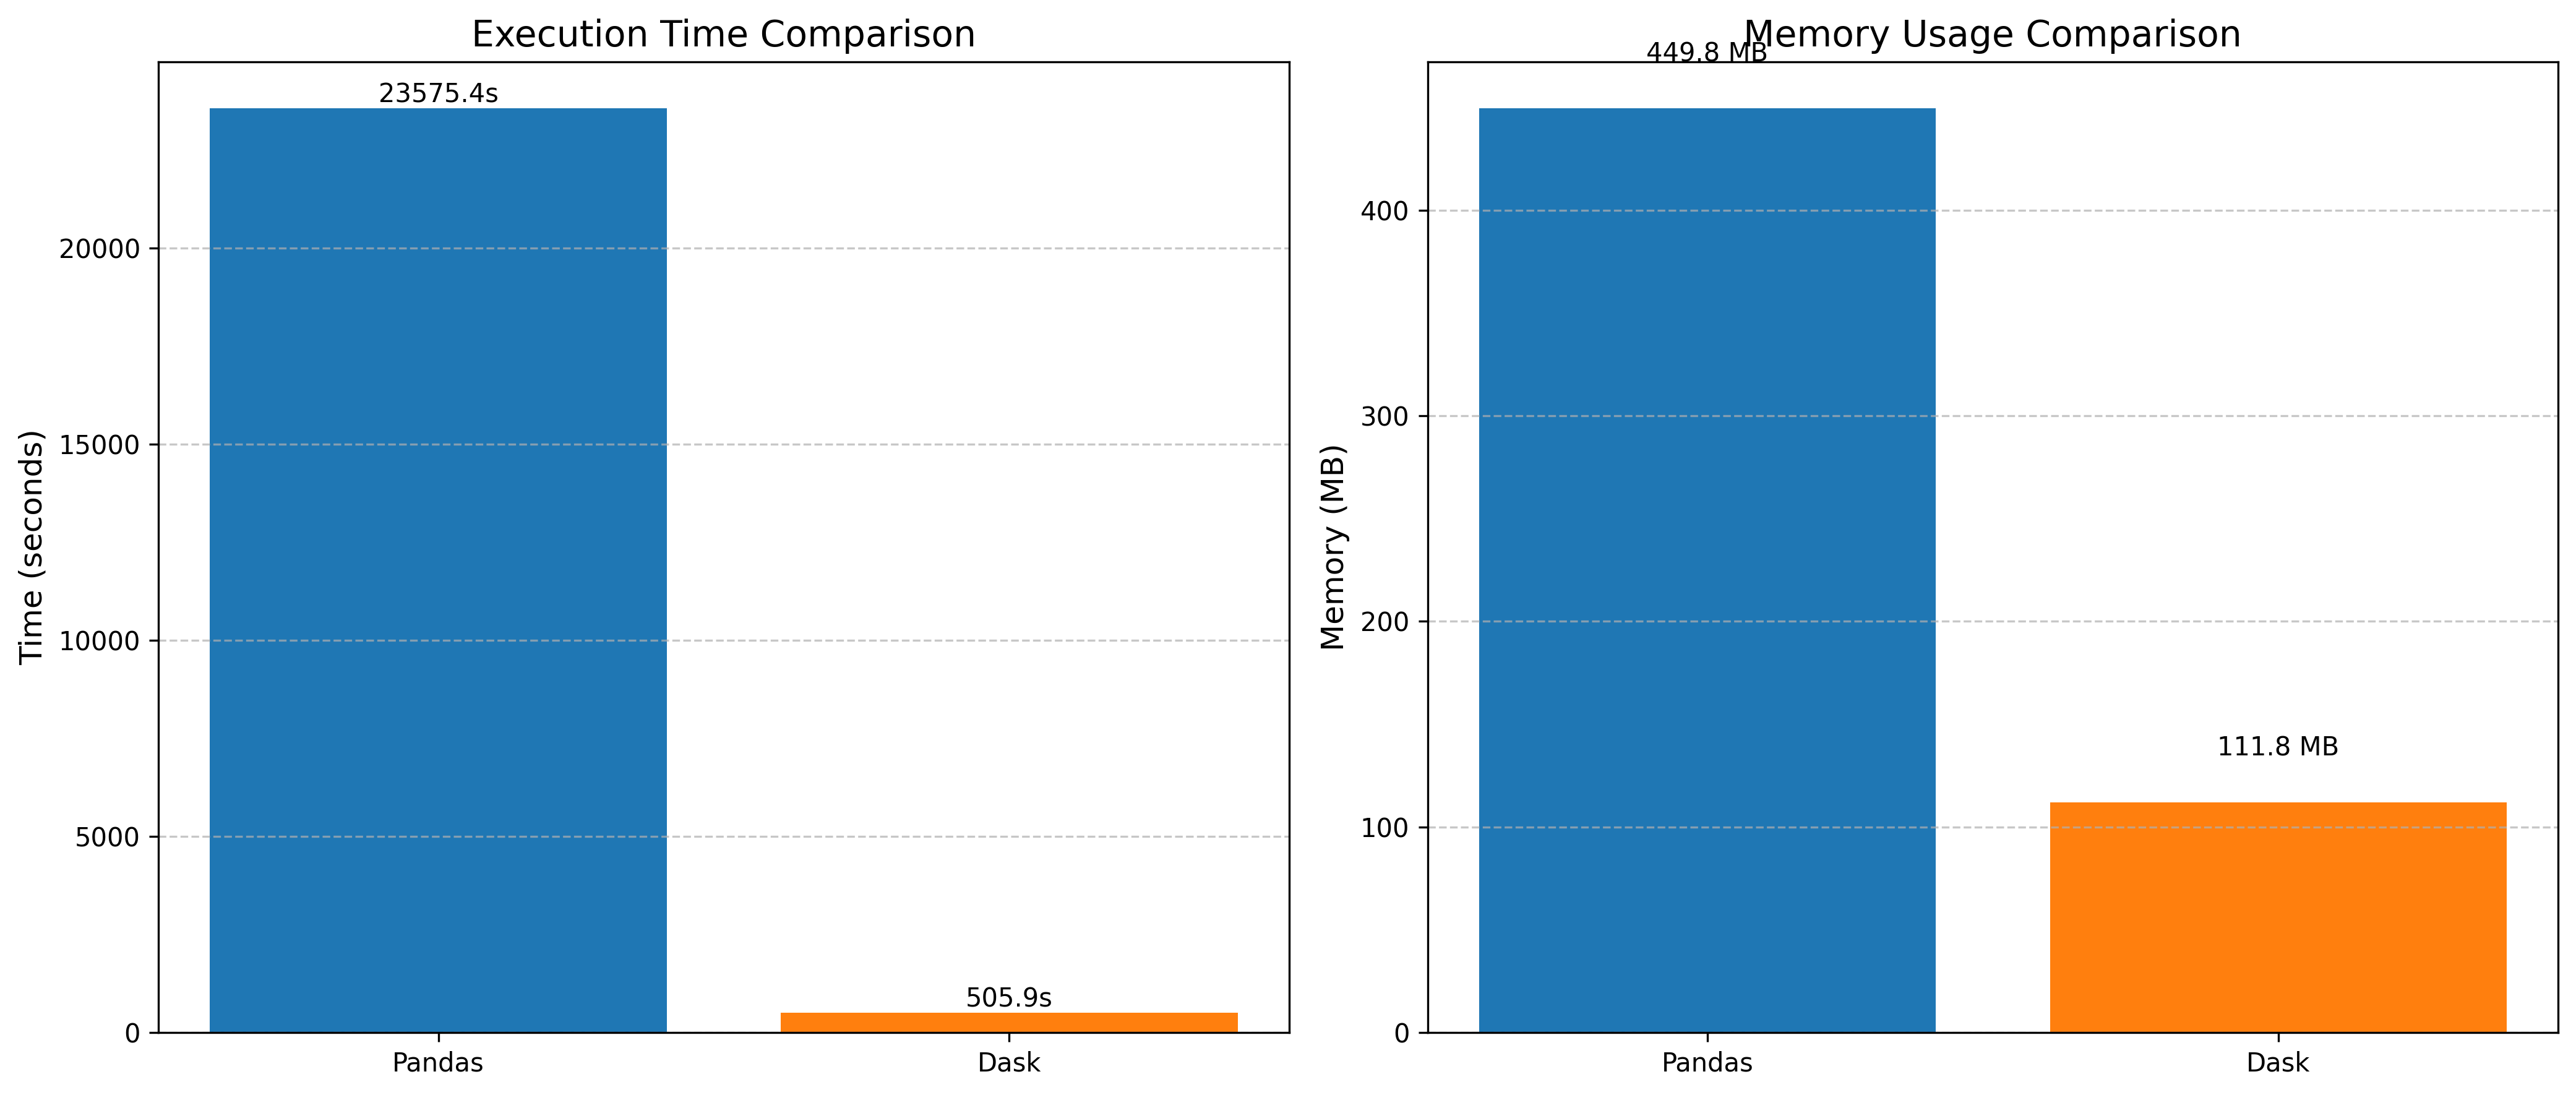